In [1]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model, Conditioned_User_simmulation_Model, Toy_intensity_Comparer, all_in_one_model

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models, process_dat
from simtrain.train import train_function_approx_multiple_variational

import simtrain.utils as utils
from simtrain.Dataset import CustomDataset, TimestepFrequencyDataset
from simtrain.train import train, train_with_negatives

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ast

import paths
from os.path import join
import pytorch_warmup as warmup
from functools import partial
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
#num_items = 7
#num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
#num_users = 11
#min_inter = 2
#max_inter = 4
state_size = SETTINGS.STATE_SIZE
subset = 20 # make data smaller
experiment_name = "intensity"
num_negatives = 150
conditioned=False
kl_weight=.01
state_size

4

# Data

## old

In [3]:
#create dataset from processed data
if False:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


In [4]:
#checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
#                             experiment_name, "data.h5"))
#list_of_dicts = checkpoint['data']

In [5]:
'''
def adjust_hidden_dim(data_dict, state_size):
    # just to jumstart experiments should be deleted at the end
    for row in list_of_dicts:
        if row["user_means"] > state_size:
            row["user_means"] = row["user_means"][:state_size]
            row["user_vars_log"] = row["user_vars_log"][:state_size]
        elif row["user_means"] > state_size:


adjust_hidden_dim(list_of_dicts, state_size)
'''


'\ndef adjust_hidden_dim(data_dict, state_size):\n    # just to jumstart experiments should be deleted at the end\n    for row in list_of_dicts:\n        if row["user_means"] > state_size:\n            row["user_means"] = row["user_means"][:state_size]\n            row["user_vars_log"] = row["user_vars_log"][:state_size]\n        elif row["user_means"] > state_size:\n\n\nadjust_hidden_dim(list_of_dicts, state_size)\n'

In [6]:
#dataset = CustomDataset(list_of_dicts[:subset]) # [:30]

#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [7]:
def test_data(dataloader):
    smallest = float("inf")
    biggest = -1
    count_classes = [0 for _ in range(num_interaction_types)]
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
        
        for i in range(num_interaction_types):
            for row in labels:
                row=torch.as_tensor(row)
                count = torch.sum(row == i)
                count_classes[i] += count

    smallest, biggest= int(smallest), float(biggest)
    print(smallest), print(biggest)
    for i in range(num_interaction_types):
        print(f"number of interactions of type {i} = {count_classes[i]}")
    return biggest

#max_time = test_data(dataloader)

In [8]:
'''
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    '''

'\nfor batch in dataloader:\n    timestamps, items, labels, means, var, idx = batch\n    print(\'Timestamps:\', timestamps#, "\n dtype: ", timestamps.dtype\n          )\n    print(\'item_recom:\', items#, "\n dtype: ", items.dtype\n          )\n    print(\'Labels:\', labels#, "\n dtype: ", labels.dtype\n          )\n    print(\'means:\', means#, "\n dtype: ", means.dtype\n          )\n    print(\'log_var:\', var#, "\n dtype: ", var.dtype\n          )\n    break\n    '

## new

In [3]:
train_sorted = False
batchsize = 64  # needs to be 1 for ode
model_type = "simple"

In [4]:
#create dataset from processed data
if True:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


{'NI': 14, 'NU': 328, 'T': '[9.708333333333334, 12.4375, 12.604166666666666, 13.395833333333334, 15.458333333333334, 15.979166666666666, 17.333333333333332, 18.6875, 20.58333333333333, 21.354166666666668, 21.375, 21.39583333333333, 21.416666666666668, 21.4375, 21.45833333333333, 21.479166666666668, 22.52083333333333, 24.39583333333333, 24.416666666666668, 24.4375, 24.45833333333333, 24.479166666666668, 24.5, 24.52083333333333, 25.479166666666668, 25.5, 25.52083333333333, 25.541666666666668, 25.58333333333333, 25.64583333333333, 29.33333333333333, 30.14583333333333, 30.58333333333333, 30.604166666666668, 30.625, 30.979166666666668, 32.0, 34.354166666666664, 36.66666666666666, 36.6875, 37.5625, 37.583333333333336, 38.583333333333336, 43.10416666666666, 43.333333333333336]', 'NS': 100, 'INF_TIME': 1000}
len:  328


In [5]:
# create dataset

dataloader_list = []
#steps_per_epoch = 0 

for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    extras = {"user_id":user["user_id"]}
    print(user["user_id"])
    dataset_for_user = TimestepFrequencyDataset(timestamps, num_random_points=num_negatives)

    dataloader = DataLoader(dataset_for_user, batch_size=batchsize, shuffle=not train_sorted
                        )
    dataloader_list.append([dataloader, means, logvars, extras])
    #steps_per_epoch += len(dataset) // batchsize  
    #if len(dataset) % batchsize != 0:
    #    steps_per_epoch += 1
steps_per_epoch = 63# for 64b 80u, for 16b 20u: 221, for 64b u20: 63

188
491
561
670
749
800
879
931
1372
1480
1622
2118
2249
2290
2725
2808
2839
2905
2920
3059


In [6]:
ids= [188,491,561,670,749,800,879,931,1372,1480,1622,2118,2249,2290,2725,2808,2839,2905,2920, 3059]

In [7]:
path_list = []
for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    reaction_ratio = [np.mean(np.array(row)) for row in user["interaction_types"]]

    path_list.append([user["timestamps"], means, logvars, reaction_ratio])

# model

## Density

In [14]:
width = 64
use_variational_nn = True
state_consistancy_training = False
intensity = {"model_hyp": {"layer_width": [width for _ in range(3)],
                           "bayesian": use_variational_nn,
                           }}
state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)],
                            "noise": 0, "bayesian": False,},
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "state_model": state_dict, 
        "intensity_model": intensity, "state_model_type": model_type, # simple
        "time_embedding_size" :32, "max_freq": 70,
        }
model = Toy_intensity_Comparer(hyperparameter_dict)
print(model)

bayesian
Toy_intensity_Comparer(
  (embed): SignWaveEmbedding()
  (user_state_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=37, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): SiLU()
      (8): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (intensity_model): User_State_Intensity_Model_simple(
    (model): Sequential(
      (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=64, bias=True)
      (1): SiLU()
      (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=

In [22]:
num_epochs = 1001
warmup_period = steps_per_epoch
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 1)//10
# restarts seem to ne be great most of the time here
user_lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=user_lr,
                        weight_decay=1e-10)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)
num_iter_til_first_restart

Using device: cpu


6300

In [23]:
from simtrain.utils import weighted_mse_loss
from simtrain.train import train_density_multiple_variational

loss = partial(weighted_mse_loss, weight_pos=10)
loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [24]:
results =train_density_multiple_variational(model, dataloader_list, criterion=weighted_mse_loss, 
            state_size=state_size, user_lr_decay=0.995, train_bayesian_weight= 0.1,
            state_consistancy_training=state_consistancy_training, consistancy_weight=.5,
            optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, user_lr=.02, device=device, 
            loss_print_interval=25, warmup_period=warmup_period, lr_scheduler=lr_scheduler,
            logging_shift = 1)


  0%|          | 0/1001 [00:00<?, ?it/s]/home/thahit/github/Recommender_Sim/simtrain/train.py:505: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  variational_means, variational_logvar = torch.tensor(variational_means,
/home/thahit/github/Recommender_Sim/simtrain/train.py:506: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).to(device), torch.tensor(variational_logvar, requires_grad=True).to(device)
/home/thahit/anaconda3/envs/WW2/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:1453: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|     

epoch: 2 loss_sum_all: 3557.977, loss_sum_freq: 3527.198, loss_sum_kl: 28.721, loss_state_consistancy: 0.000, lr: 0.0010000, userlr: 0.0200000


  3%|▎         | 26/1001 [00:11<07:19,  2.22it/s]

epoch: 27 loss_sum_all: 3693.825, loss_sum_freq: 3609.681, loss_sum_kl: 82.087, loss_state_consistancy: 0.000, lr: 0.0008547, userlr: 0.0176444


  5%|▌         | 51/1001 [00:23<07:15,  2.18it/s]

epoch: 52 loss_sum_all: 1645.244, loss_sum_freq: 1581.174, loss_sum_kl: 61.975, loss_state_consistancy: 0.000, lr: 0.0005043, userlr: 0.0155663


  8%|▊         | 76/1001 [00:35<07:51,  1.96it/s]

epoch: 77 loss_sum_all: 1219.551, loss_sum_freq: 1176.370, loss_sum_kl: 41.164, loss_state_consistancy: 0.000, lr: 0.0001532, userlr: 0.0137329


 10%|█         | 101/1001 [00:49<08:04,  1.86it/s]

epoch: 102 loss_sum_all: 1491.501, loss_sum_freq: 1446.650, loss_sum_kl: 42.769, loss_state_consistancy: 0.000, lr: 0.0010000, userlr: 0.0121154


 13%|█▎        | 126/1001 [01:08<15:11,  1.04s/it]

epoch: 127 loss_sum_all: 1490.254, loss_sum_freq: 1441.387, loss_sum_kl: 46.721, loss_state_consistancy: 0.000, lr: 0.0008513, userlr: 0.0106885


 15%|█▌        | 151/1001 [01:29<09:03,  1.57it/s]

epoch: 152 loss_sum_all: 1178.930, loss_sum_freq: 1119.367, loss_sum_kl: 57.441, loss_state_consistancy: 0.000, lr: 0.0004971, userlr: 0.0094296


 18%|█▊        | 176/1001 [01:44<07:03,  1.95it/s]

epoch: 177 loss_sum_all: 993.666, loss_sum_freq: 960.272, loss_sum_kl: 31.260, loss_state_consistancy: 0.000, lr: 0.0001501, userlr: 0.0083190


 20%|██        | 201/1001 [01:58<06:54,  1.93it/s]

epoch: 202 loss_sum_all: 1488.185, loss_sum_freq: 1457.255, loss_sum_kl: 28.733, loss_state_consistancy: 0.000, lr: 0.0009999, userlr: 0.0073392


 23%|██▎       | 226/1001 [02:12<06:53,  1.88it/s]

epoch: 227 loss_sum_all: 1183.261, loss_sum_freq: 1150.215, loss_sum_kl: 30.938, loss_state_consistancy: 0.000, lr: 0.0008531, userlr: 0.0064748


 25%|██▌       | 251/1001 [02:25<06:39,  1.88it/s]

epoch: 252 loss_sum_all: 2006.014, loss_sum_freq: 1955.951, loss_sum_kl: 47.842, loss_state_consistancy: 0.000, lr: 0.0005025, userlr: 0.0057122


 28%|██▊       | 276/1001 [02:39<06:52,  1.76it/s]

epoch: 277 loss_sum_all: 1442.265, loss_sum_freq: 1401.050, loss_sum_kl: 39.031, loss_state_consistancy: 0.000, lr: 0.0001541, userlr: 0.0050394


 30%|███       | 301/1001 [02:53<06:21,  1.84it/s]

epoch: 302 loss_sum_all: 835.256, loss_sum_freq: 798.256, loss_sum_kl: 34.820, loss_state_consistancy: 0.000, lr: 0.0010000, userlr: 0.0044458


 33%|███▎      | 326/1001 [03:07<06:19,  1.78it/s]

epoch: 327 loss_sum_all: 744.628, loss_sum_freq: 710.219, loss_sum_kl: 32.175, loss_state_consistancy: 0.000, lr: 0.0008555, userlr: 0.0039222


 35%|███▌      | 351/1001 [03:21<06:08,  1.76it/s]

epoch: 352 loss_sum_all: 1803.178, loss_sum_freq: 1756.922, loss_sum_kl: 44.054, loss_state_consistancy: 0.000, lr: 0.0005080, userlr: 0.0034603


 38%|███▊      | 376/1001 [03:35<05:59,  1.74it/s]

epoch: 377 loss_sum_all: 1195.291, loss_sum_freq: 1166.922, loss_sum_kl: 26.271, loss_state_consistancy: 0.000, lr: 0.0001580, userlr: 0.0030527


 40%|████      | 401/1001 [03:49<05:23,  1.85it/s]

epoch: 402 loss_sum_all: 337.953, loss_sum_freq: 326.145, loss_sum_kl: 9.785, loss_state_consistancy: 0.000, lr: 0.0000100, userlr: 0.0026932


 43%|████▎     | 426/1001 [04:03<05:14,  1.83it/s]

epoch: 427 loss_sum_all: 1184.140, loss_sum_freq: 1159.479, loss_sum_kl: 22.528, loss_state_consistancy: 0.000, lr: 0.0008564, userlr: 0.0023760


 45%|████▌     | 451/1001 [04:17<05:06,  1.79it/s]

epoch: 452 loss_sum_all: 754.382, loss_sum_freq: 737.712, loss_sum_kl: 14.615, loss_state_consistancy: 0.000, lr: 0.0005082, userlr: 0.0020961


 48%|████▊     | 476/1001 [04:31<04:40,  1.87it/s]

epoch: 477 loss_sum_all: 1087.377, loss_sum_freq: 1067.699, loss_sum_kl: 17.640, loss_state_consistancy: 0.000, lr: 0.0001576, userlr: 0.0018492


 50%|█████     | 501/1001 [04:45<04:00,  2.08it/s]

epoch: 502 loss_sum_all: 1140.977, loss_sum_freq: 1117.602, loss_sum_kl: 21.266, loss_state_consistancy: 0.000, lr: 0.0000100, userlr: 0.0016314


 53%|█████▎    | 526/1001 [04:59<04:09,  1.91it/s]

epoch: 527 loss_sum_all: 1687.614, loss_sum_freq: 1659.064, loss_sum_kl: 26.487, loss_state_consistancy: 0.000, lr: 0.0008554, userlr: 0.0014393


 55%|█████▌    | 551/1001 [05:13<04:02,  1.86it/s]

epoch: 552 loss_sum_all: 492.098, loss_sum_freq: 476.479, loss_sum_kl: 13.577, loss_state_consistancy: 0.000, lr: 0.0005070, userlr: 0.0012698


 58%|█████▊    | 576/1001 [05:27<03:52,  1.83it/s]

epoch: 577 loss_sum_all: 669.439, loss_sum_freq: 654.343, loss_sum_kl: 13.079, loss_state_consistancy: 0.000, lr: 0.0001555, userlr: 0.0011202


 60%|██████    | 601/1001 [05:41<03:43,  1.79it/s]

epoch: 602 loss_sum_all: 469.924, loss_sum_freq: 459.011, loss_sum_kl: 8.898, loss_state_consistancy: 0.000, lr: 0.0000100, userlr: 0.0009883


 63%|██████▎   | 626/1001 [05:55<03:19,  1.88it/s]

epoch: 627 loss_sum_all: 689.919, loss_sum_freq: 671.301, loss_sum_kl: 16.593, loss_state_consistancy: 0.000, lr: 0.0008562, userlr: 0.0008719


 65%|██████▌   | 651/1001 [06:10<03:52,  1.51it/s]

epoch: 652 loss_sum_all: 442.309, loss_sum_freq: 424.815, loss_sum_kl: 15.497, loss_state_consistancy: 0.000, lr: 0.0005065, userlr: 0.0007692


 68%|██████▊   | 676/1001 [06:26<03:14,  1.67it/s]

epoch: 677 loss_sum_all: 283.285, loss_sum_freq: 260.718, loss_sum_kl: 20.547, loss_state_consistancy: 0.000, lr: 0.0001548, userlr: 0.0006786


 70%|███████   | 701/1001 [06:41<03:10,  1.57it/s]

epoch: 702 loss_sum_all: 1095.204, loss_sum_freq: 1074.417, loss_sum_kl: 18.769, loss_state_consistancy: 0.000, lr: 0.0000100, userlr: 0.0005987


 73%|███████▎  | 726/1001 [06:55<02:23,  1.91it/s]

epoch: 727 loss_sum_all: 1874.109, loss_sum_freq: 1854.687, loss_sum_kl: 17.315, loss_state_consistancy: 0.000, lr: 0.0008580, userlr: 0.0005282


 75%|███████▌  | 751/1001 [07:09<02:30,  1.66it/s]

epoch: 752 loss_sum_all: 826.148, loss_sum_freq: 803.404, loss_sum_kl: 20.555, loss_state_consistancy: 0.000, lr: 0.0005129, userlr: 0.0004660


 78%|███████▊  | 776/1001 [07:23<02:06,  1.78it/s]

epoch: 777 loss_sum_all: 954.757, loss_sum_freq: 933.490, loss_sum_kl: 19.101, loss_state_consistancy: 0.000, lr: 0.0001585, userlr: 0.0004111


 80%|████████  | 801/1001 [07:37<01:54,  1.74it/s]

epoch: 802 loss_sum_all: 1317.335, loss_sum_freq: 1290.541, loss_sum_kl: 24.576, loss_state_consistancy: 0.000, lr: 0.0000100, userlr: 0.0003627


 83%|████████▎ | 826/1001 [07:51<01:35,  1.84it/s]

epoch: 827 loss_sum_all: 908.933, loss_sum_freq: 894.099, loss_sum_kl: 12.759, loss_state_consistancy: 0.000, lr: 0.0008588, userlr: 0.0003199


 85%|████████▌ | 851/1001 [08:06<01:30,  1.65it/s]

epoch: 852 loss_sum_all: 1351.232, loss_sum_freq: 1331.854, loss_sum_kl: 17.205, loss_state_consistancy: 0.000, lr: 0.0005099, userlr: 0.0002823


 88%|████████▊ | 876/1001 [08:20<01:11,  1.74it/s]

epoch: 877 loss_sum_all: 527.333, loss_sum_freq: 516.906, loss_sum_kl: 8.345, loss_state_consistancy: 0.000, lr: 0.0001576, userlr: 0.0002490


 90%|█████████ | 901/1001 [08:33<00:53,  1.87it/s]

epoch: 902 loss_sum_all: 551.774, loss_sum_freq: 534.835, loss_sum_kl: 14.871, loss_state_consistancy: 0.000, lr: 0.0000100, userlr: 0.0002197


 93%|█████████▎| 926/1001 [08:47<00:41,  1.82it/s]

epoch: 927 loss_sum_all: 1058.337, loss_sum_freq: 1044.218, loss_sum_kl: 12.068, loss_state_consistancy: 0.000, lr: 0.0008616, userlr: 0.0001938


 95%|█████████▌| 951/1001 [09:01<00:27,  1.82it/s]

epoch: 952 loss_sum_all: 427.023, loss_sum_freq: 416.954, loss_sum_kl: 8.074, loss_state_consistancy: 0.000, lr: 0.0005134, userlr: 0.0001710


 98%|█████████▊| 976/1001 [09:15<00:13,  1.91it/s]

epoch: 977 loss_sum_all: 828.498, loss_sum_freq: 816.509, loss_sum_kl: 9.998, loss_state_consistancy: 0.000, lr: 0.0001638, userlr: 0.0001508


100%|██████████| 1001/1001 [09:30<00:00,  1.76it/s]

epoch: 1002 loss_sum_all: 303.164, loss_sum_freq: 287.591, loss_sum_kl: 13.586, loss_state_consistancy: 0.000, lr: 0.0000102, userlr: 0.0001331
epoch: 1002 loss_sum_all: 303.164, loss_sum_freq: 287.591, loss_sum_kl: 13.586, loss_state_consistancy: 0.000, lr: 0.0000102, userlr: 0.0001324


In [18]:
cycycyc

NameError: name 'cycycyc' is not defined

### visualization

800
area: 9.41437957763672


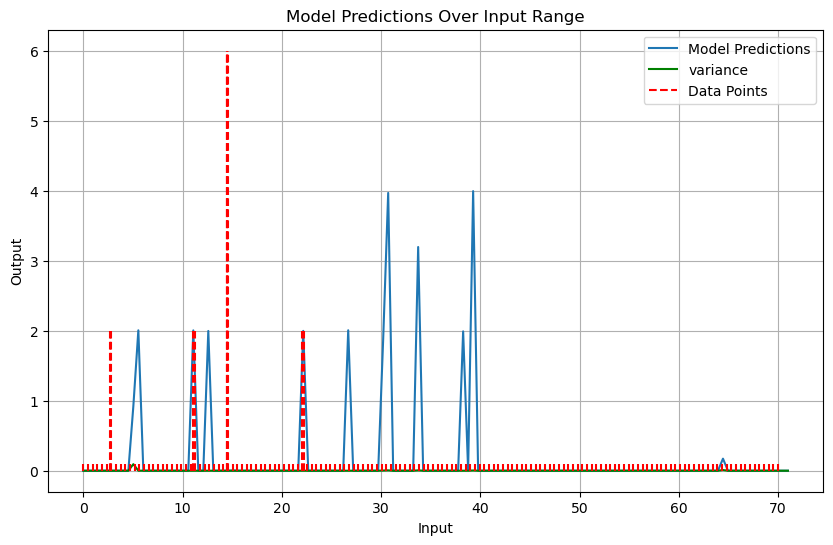

In [40]:
# 11, 10, 4, 0, 13, 15
# good ones: 4=491? , 13=2290, 
selected_user = 4
dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
print(extras["user_id"])
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        if use_variational_nn:
            predictions_list = []
            for _ in range(20):
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                predictions_list.append(predictions)
                #print("variance of states: ", torch.var(states))
            predictions_list = np.stack(predictions_list)
            predictions = np.mean(predictions_list, axis=0)
            var = np.var(predictions_list, axis=0)
            cond = (0.1>var) | (var <.01)
            #predictions = np.where(cond , predictions, 0)


        else:
            state = torch.tensor(variational_means).repeat(len(x_range),1)
            predictions, states = model(state, x_range_tensor, return_new_state=True)
            predictions = predictions.numpy()
            #print("variance of states: ", torch.var(states))

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

if use_variational_nn:
    plt.plot(x_range, var, label='variance', color="green")

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

user:  879
area: 45.319652709960934


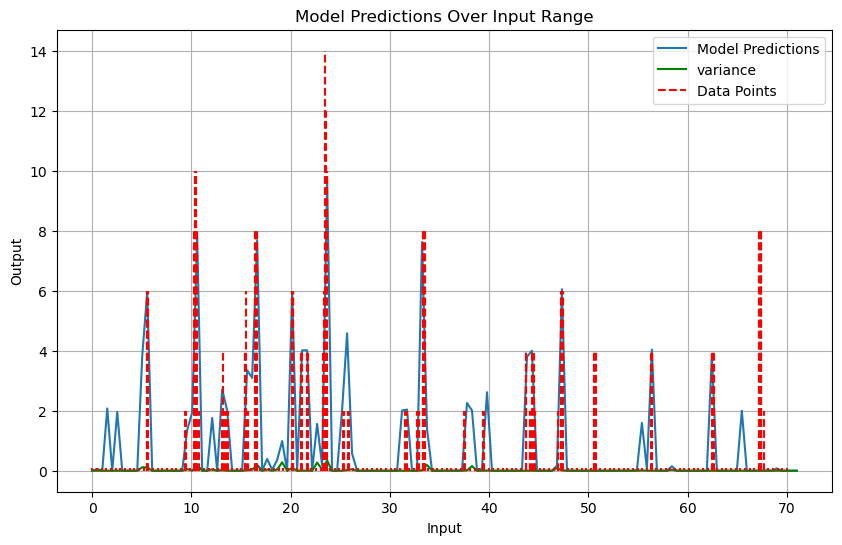

user:  2290
area: 27.665568237304687


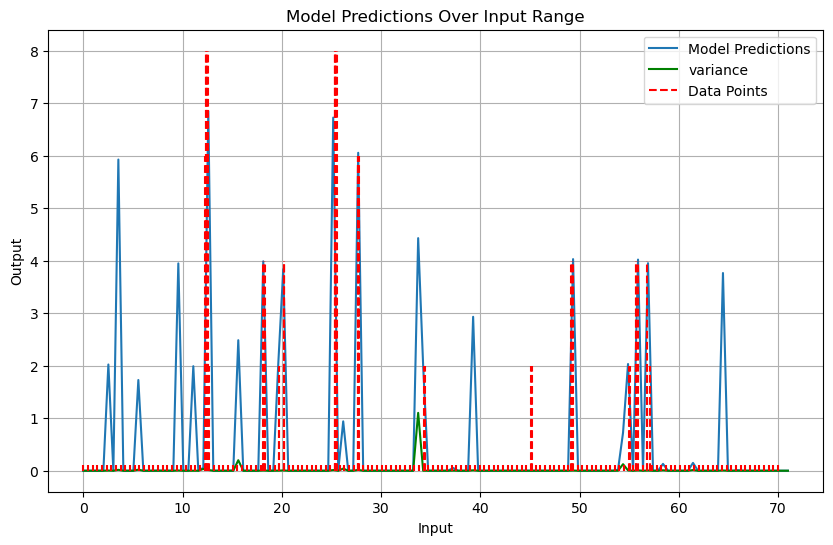

user:  2118
area: 10.42209846496582


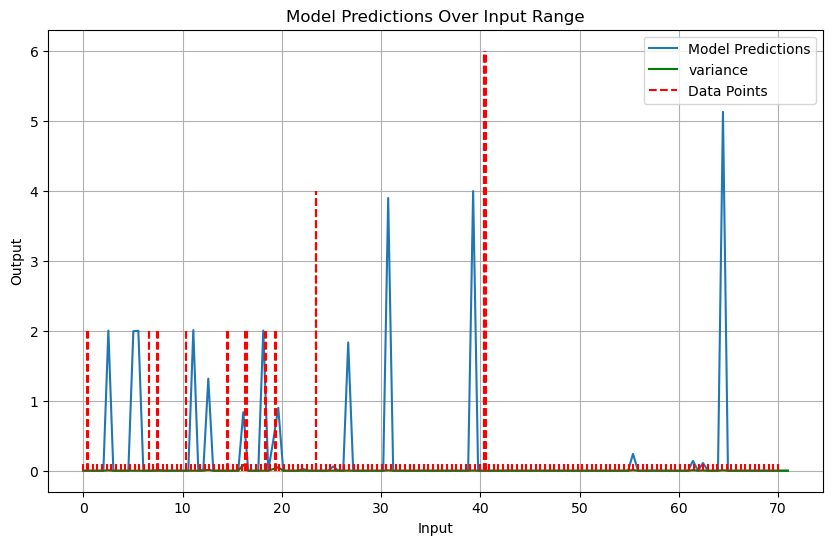

user:  1372
area: 8.749591369628906


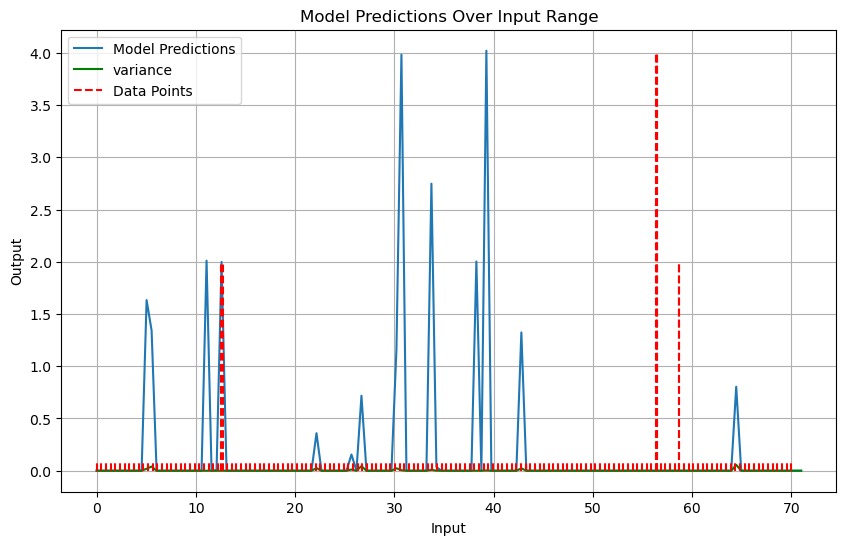

user:  800
area: 9.498573303222656


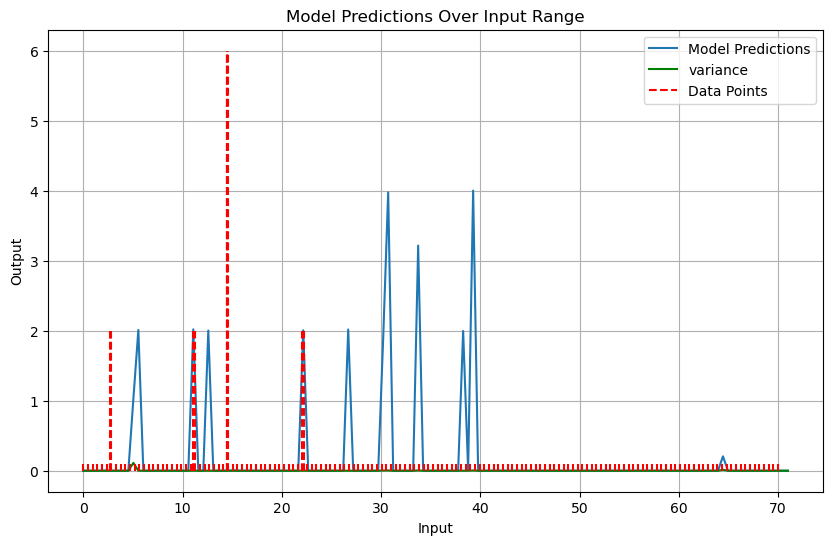

user:  2725
area: 9.134951934814453


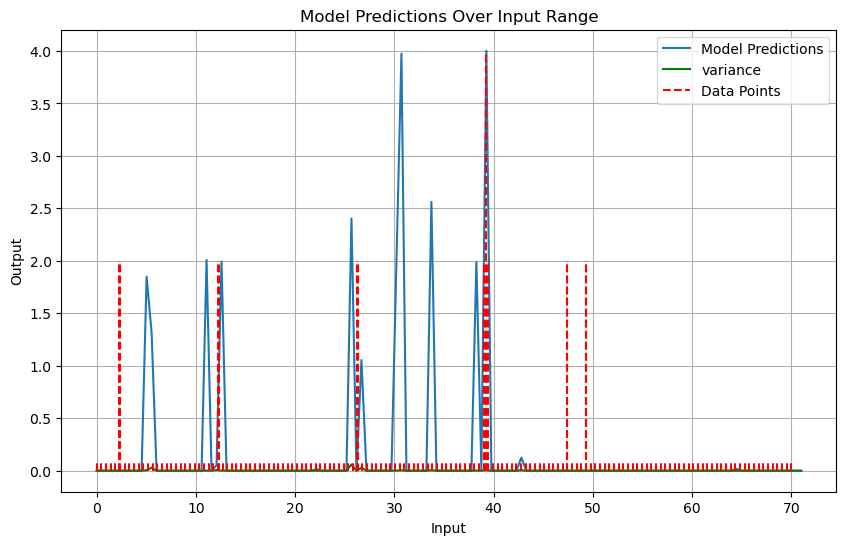

user:  2920
area: 21.436550903320313


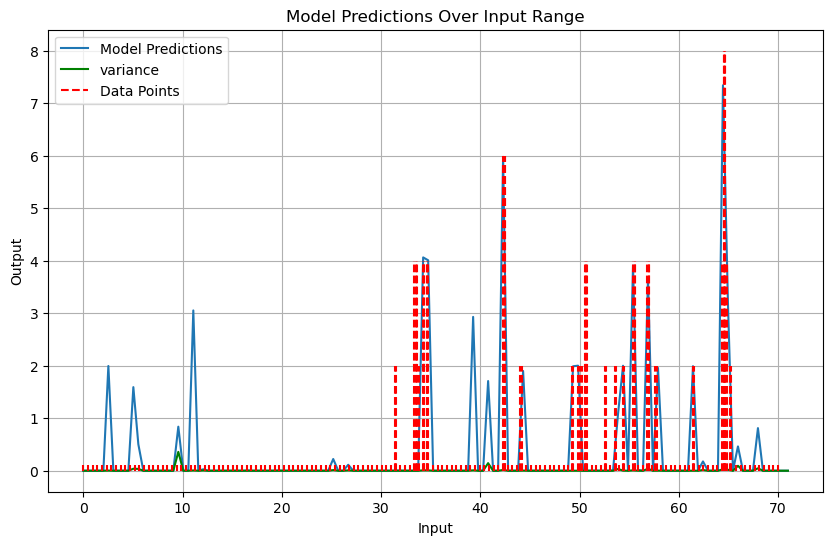

user:  2905
area: 13.58316925048828


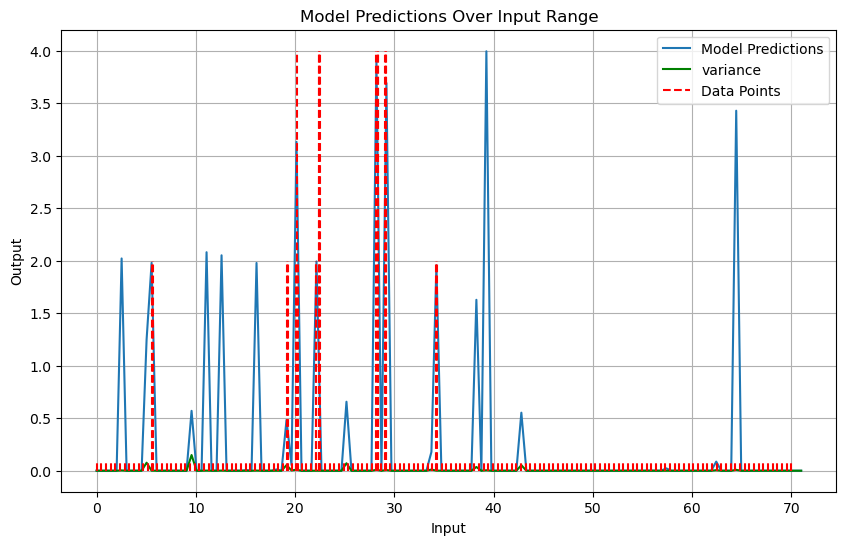

user:  670
area: 9.173291473388671


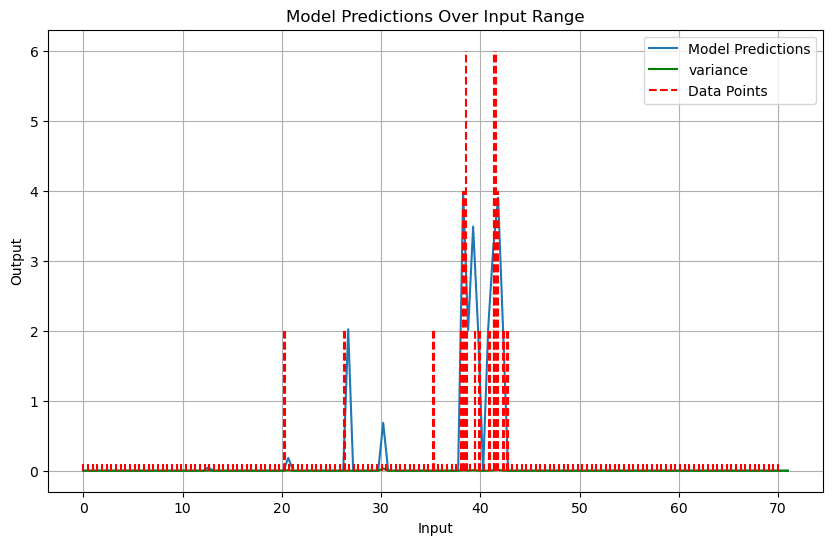

user:  188
area: 12.455599822998046


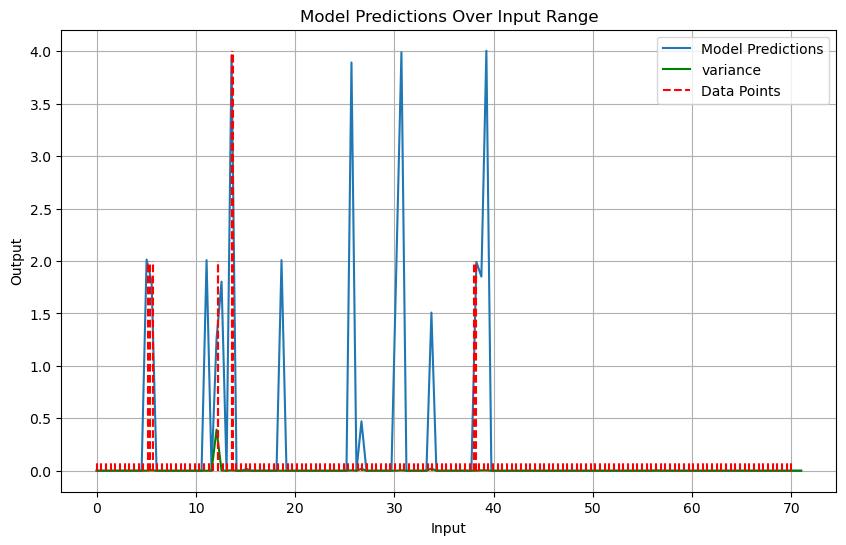

user:  3059
area: 9.895094604492186


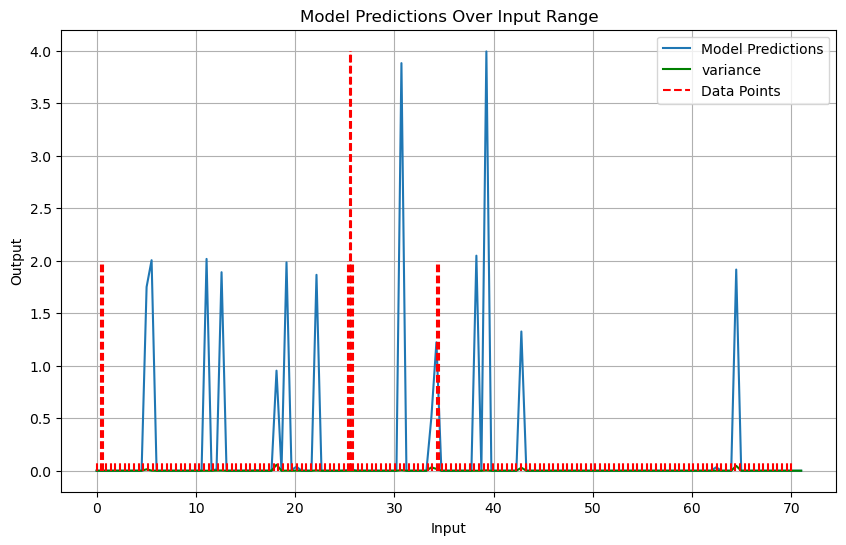

user:  2839
area: 8.639366912841796


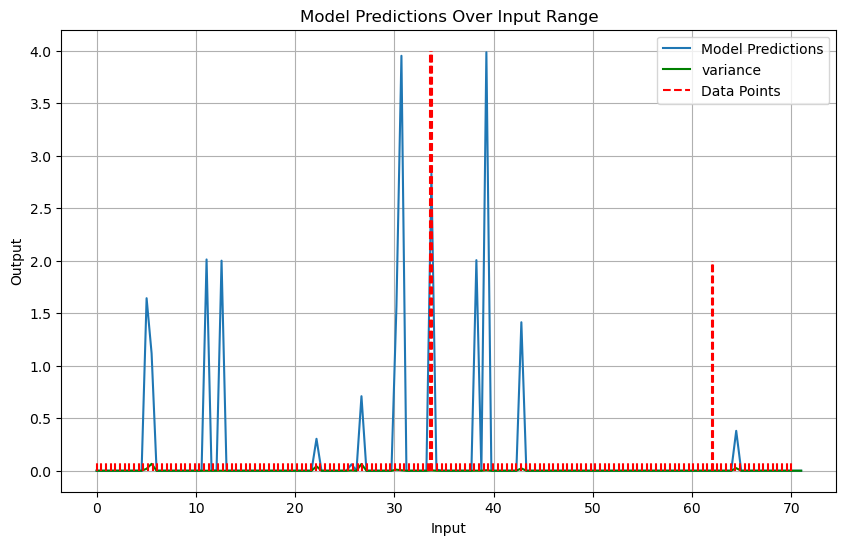

user:  1480
area: 13.14715621948242


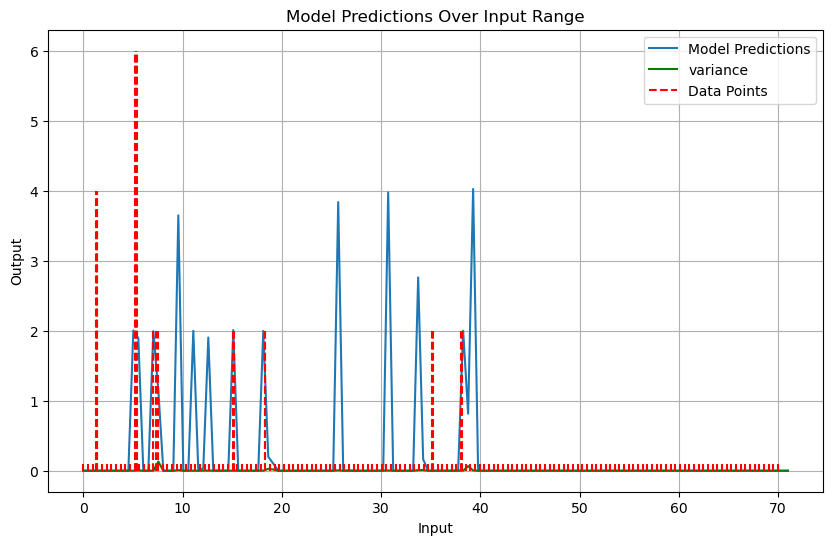

user:  561
area: 9.965435943603515


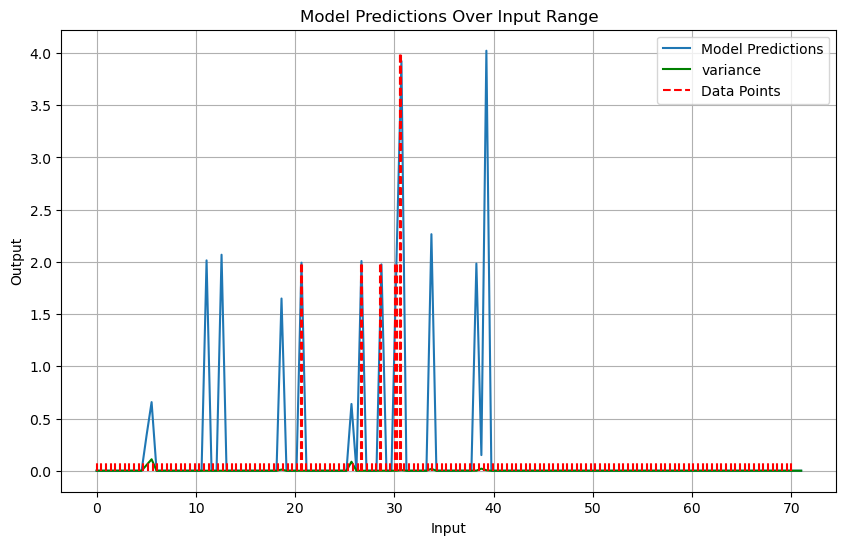

user:  2808
area: 52.10563293457031


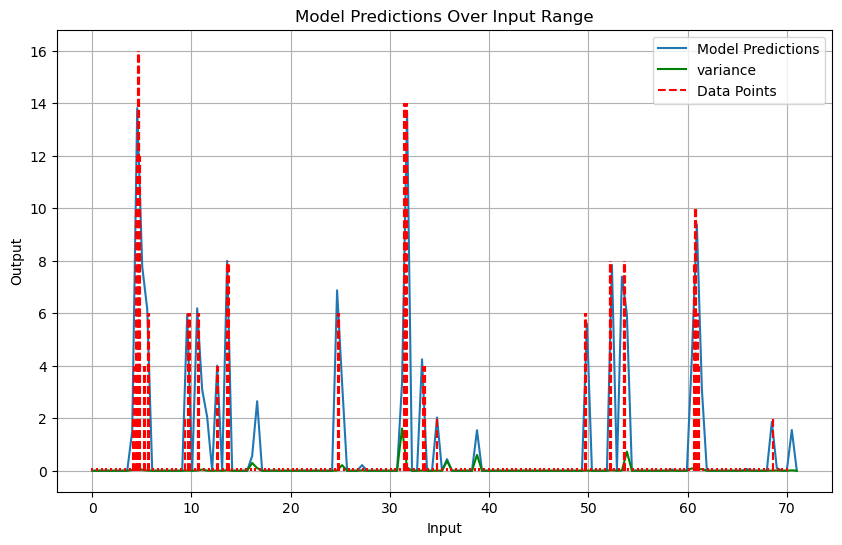

user:  749
area: 10.93300323486328


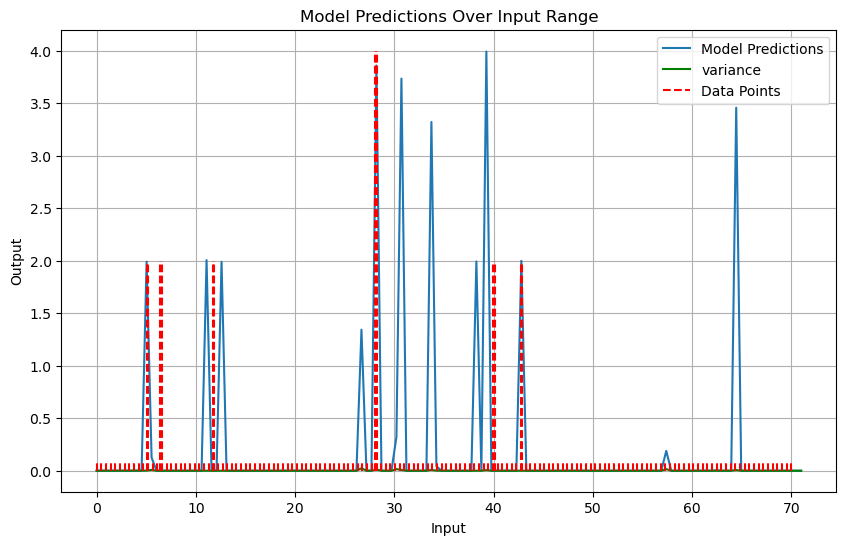

user:  1622
area: 56.20570861816406


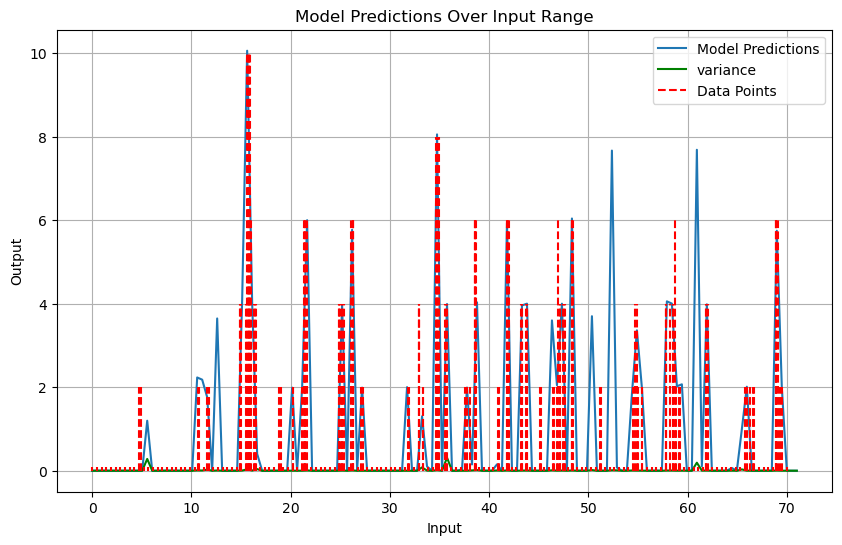

user:  931
area: 12.871507873535156


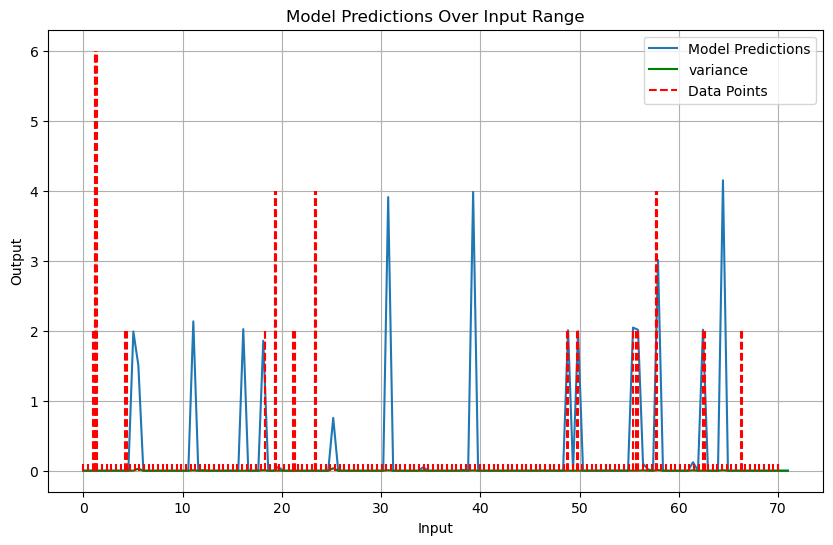

user:  491
area: 11.688447875976562


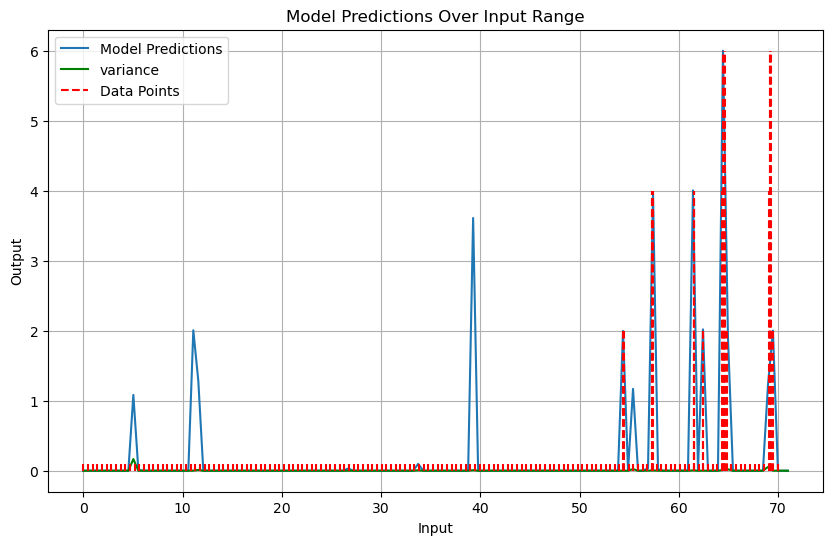

user:  2249
area: 17.182293090820313


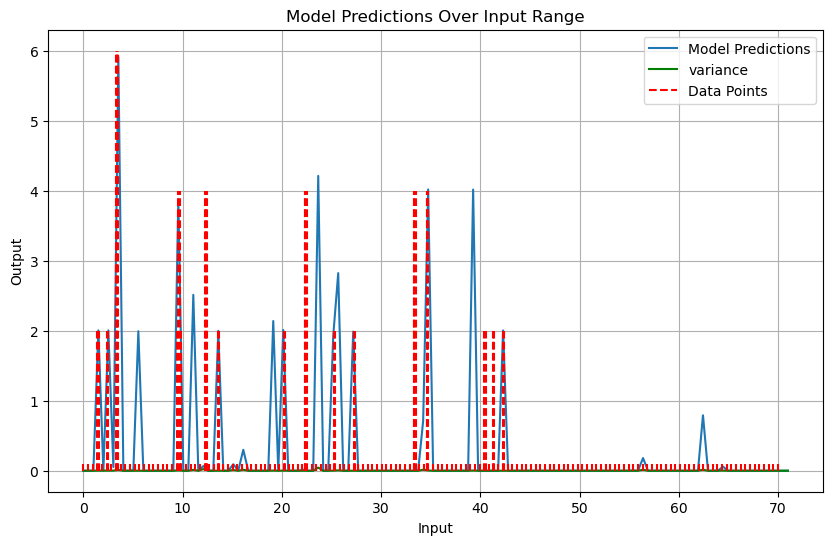

In [44]:
for selected_user in range(len(dataloader_list)):
    # 11, 10, 4, 0, 13, 15
    # good ones: 4=491? , 13=2290, 
    dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
    print("user: ", extras["user_id"])
    dataset = dataloader.dataset
    x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
    x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
    model.eval()
    with torch.no_grad():
        if model_type == "ode":
            raise NotImplementedError
            state = torch.zeros((1, state_size))

            predictions = []
            for el in x_range:
                out = model(state, el)
                predictions.append(out[0])
        else:
            if use_variational_nn:
                predictions_list = []
                for _ in range(20):
                    state = torch.tensor(variational_means).repeat(len(x_range),1)
                    predictions, states = model(state, x_range_tensor, return_new_state=True)
                    predictions = predictions.numpy()
                    predictions_list.append(predictions)
                    #print("variance of states: ", torch.var(states))
                predictions_list = np.stack(predictions_list)
                predictions = np.mean(predictions_list, axis=0)
                var = np.var(predictions_list, axis=0)
                cond = (0.1>var) | (var <.01)
                #predictions = np.where(cond , predictions, 0)


            else:
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                #print("variance of states: ", torch.var(states))

    print(f"area: {np.sum(predictions)*(72/200)}")
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x_range, predictions, label='Model Predictions')

    if use_variational_nn:
        plt.plot(x_range, var, label='variance', color="green")

    for i in range(len(dataset)):
        sample = dataset[i]
        x_pos= sample['timestep'].item()
        height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
        plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

    plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

    #plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Model Predictions Over Input Range')
    plt.legend()
    plt.grid(True)
    plt.show()

879
area: 48.91515380859375


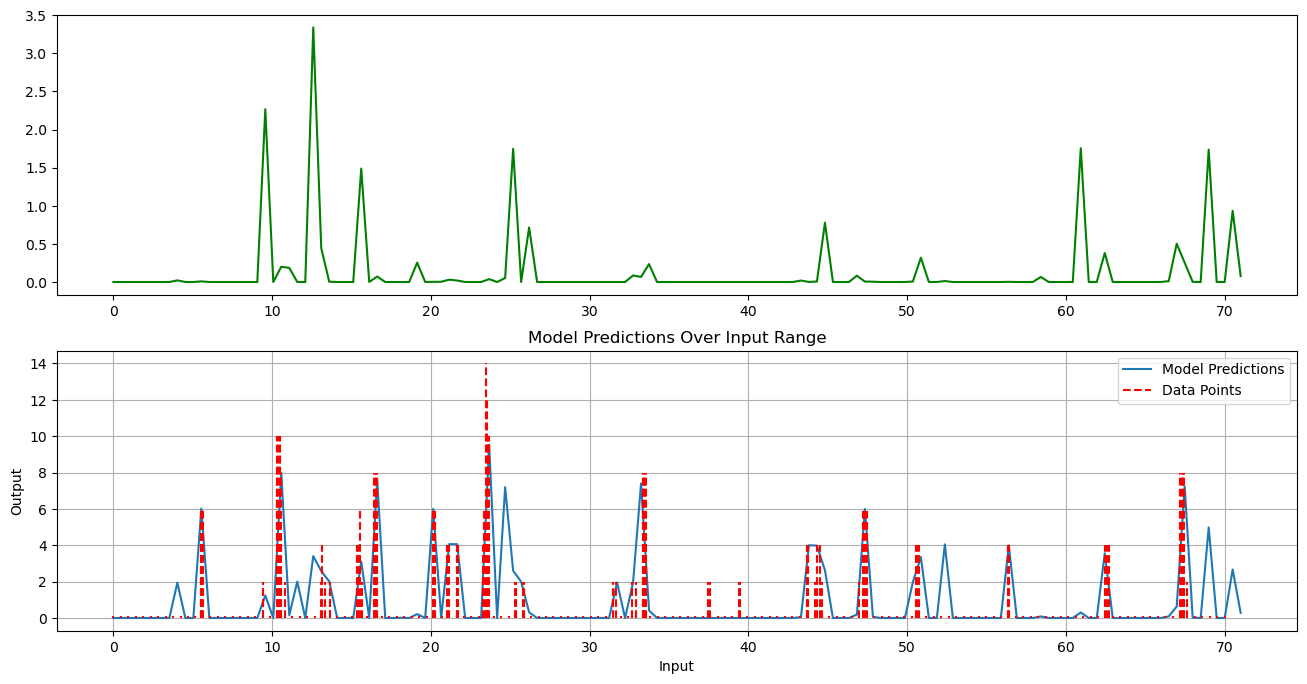

In [ ]:
# ugly version
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

selected_user = 11
dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
print(extras["user_id"])
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        if use_variational_nn:
            predictions_list = []
            for _ in range(20):
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                predictions_list.append(predictions)
                #print("variance of states: ", torch.var(states))
            predictions_list = np.stack(predictions_list)
            predictions = np.mean(predictions_list, axis=0)
            var = np.var(predictions_list, axis=0)
            cond = (0.1>var) | (var <.01)
            predictions = np.where(cond.any() , predictions, 0)


        else:
            state = torch.tensor(variational_means).repeat(len(x_range),1)
            predictions, states = model(state, x_range_tensor, return_new_state=True)
            predictions = predictions.numpy()
            print("variance of states: ", torch.var(states))

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.plot(x_range, predictions, label='Model Predictions')

if use_variational_nn:
    axs[0].plot(x_range, var, label='variance', color="green")

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sdfsd  # 30 users below

area: 64.883671875


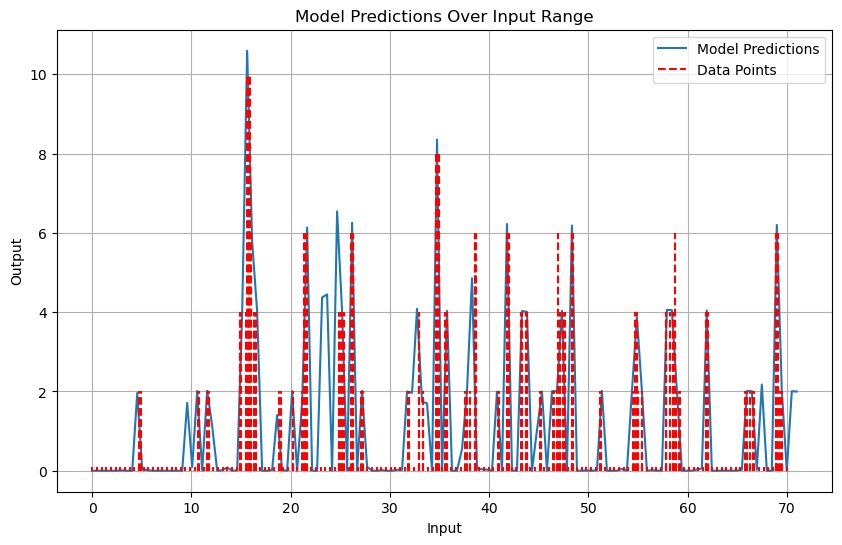

In [ ]:
selected_user = 10
dataloader, variational_means, variational_logvar = dataloader_list[selected_user]
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        state = torch.tensor(variational_means).repeat(len(x_range),1)
        predictions = model(state, x_range_tensor).numpy()

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
assdad

## function Approx. sampling

In [8]:
width=64
use_jump = False
user_state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)]}}
time_dict = {"model_hyp": {"layer_width": [width for _ in range(3)]}
            }
jump_dict= {"model_hyp": {"layer_width": [8, 8]}
            }


timecheat = False
hyperparameter_dict = {"state_size": state_size, "time_model": time_dict, 
                           "state_model": user_state_dict,
                           "jump_model": jump_dict}
train_model = all_in_one_model(hyperparameter_dict, timecheat=timecheat, noise_size=1)
print(train_model)

all_in_one_model(
  (time_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (state_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): SiLU()
      (8): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (jump_model): Jump_Model_ratio(
    (model): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): SiLU()
      (2): Linear(in_features=8, out_f

In [9]:
print(train_model)

all_in_one_model(
  (time_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (state_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): SiLU()
      (8): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (jump_model): Jump_Model_ratio(
    (model): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): SiLU()
      (2): Linear(in_features=8, out_f

In [11]:
steps_per_epoch = len(dataloader_list)

num_epochs = 401
warmup_period = steps_per_epoch * 1
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 1)//4
user_lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(train_model.parameters(), lr=user_lr,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [12]:
from simtrain.utils import weighted_mse_loss

loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [13]:
train_function_approx_multiple_variational(train_model, path_list, scoring_func=utils.energy_score_loss,
            device=device, user_lr=0.01, user_lr_decay=0.995,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, logging_shift=1,
            state_size=state_size, warmup_scheduler=warmup_scheduler, lr_scheduler=lr_scheduler,
            optimizer=optimizer, num_epochs=num_epochs, num_tries=30, timecheat=timecheat, 
            loss_print_interval=25, include_jump=use_jump,
            warmup_period=warmup_period)


  0%|          | 1/401 [00:02<16:11,  2.43s/it]/home/thahit/anaconda3/envs/WW2/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:1453: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 2/401 [00:04<15:10,  2.28s/it]

epoch: 2 loss_sum_all: 3731.2061, loss_sum_freq: 1942.3992385864258, loss_sum_kl: 1788.8068389892578, lr: 0.0009997, userlr: 0.0099500


  7%|▋         | 27/401 [01:11<19:03,  3.06s/it]

epoch: 27 loss_sum_all: 2203.0523, loss_sum_freq: 1474.5572624206543, loss_sum_kl: 728.4949913024902, lr: 0.0008433, userlr: 0.0087781


 13%|█▎        | 52/401 [02:52<26:35,  4.57s/it]

epoch: 52 loss_sum_all: 1670.7658, loss_sum_freq: 1423.230463027954, loss_sum_kl: 247.53535056114197, lr: 0.0004887, userlr: 0.0077442


 19%|█▉        | 77/401 [04:48<27:41,  5.13s/it]

epoch: 77 loss_sum_all: 1404.1810, loss_sum_freq: 1285.2252254486084, loss_sum_kl: 118.95580911636353, lr: 0.0001436, userlr: 0.0068321


 25%|██▌       | 102/401 [06:30<20:48,  4.17s/it]

epoch: 102 loss_sum_all: 1507.3668, loss_sum_freq: 1415.18088722229, loss_sum_kl: 92.18590700626373, lr: 0.0009997, userlr: 0.0060274


 32%|███▏      | 127/401 [07:39<12:17,  2.69s/it]

epoch: 127 loss_sum_all: 1398.0013, loss_sum_freq: 1301.7731266021729, loss_sum_kl: 96.22816812992096, lr: 0.0008433, userlr: 0.0053175


 32%|███▏      | 129/401 [07:45<13:13,  2.92s/it]

In [ ]:
steps_per_epoch = len(dataloader_list)

num_epochs = 801
warmup_period = steps_per_epoch * 1
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 1)
user_lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(train_model.parameters(), lr=user_lr,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-6)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


In [ ]:
train_function_approx_multiple_variational(train_model, path_list, scoring_func=utils.energy_score_loss,
            device=device, user_lr=0.001, user_lr_decay=0.995,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, logging_shift=1,
            state_size=state_size, warmup_scheduler=warmup_scheduler, lr_scheduler=lr_scheduler,
            optimizer=optimizer, num_epochs=num_epochs, num_tries=30, timecheat=timecheat, 
            loss_print_interval=25, include_jump=use_jump,
            warmup_period=warmup_period)


### visualization

In [ ]:
def simulate_single_forced_function_approx(model, user_data, state_size, use_jump=False,
                                           timecheat=False, num_tries=20, state=None):
    
    last_t = 0
    if (state is None):
        state = torch.zeros((1, state_size))
    path, variational_means, variational_logvar, reaction_ratio = user_data
    results = []
    with torch.no_grad():
        for interaction_id in range(len(path)):
            timestep = path[interaction_id]
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                #print(f"next_time: {next_time}, next_state: {next_state}")
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            last_t = timestep
            state = model.get_new_state(state, torch.tensor([[timestep]]))
            if use_jump:
                    reactions_ratio_tensor = torch.tensor(reaction_ratio[interaction_id], dtype=torch.float32).view(1,-1)
                    state = model.jump(state, reactions_ratio_tensor)
    
    return results

def simulate_single_function_approx(model, state_size, num_events=10, 
            timecheat=False, num_tries=20, state=None, use_jump=False,):
    if use_jump:
        raise NotImplementedError# what should this do?
    
    last_t = 0
    if (state is None):
        state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for _ in range(num_events):
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            selected = torch.mean(current_pred)
            results.append(selected)
            last_t = selected
            state = model.get_new_state(state, torch.tensor([[selected]]))
    
    return results

In [ ]:
user_id = 8
sample_path = path_list[user_id]
state = torch.tensor([sample_path[1]])
len(sample_path[0]), state

(12, tensor([[-0.0044, -0.1319,  0.0402, -0.0650]]))

In [ ]:
# simpler nn
simulate_single_partial_forced_function_approx = partial(
    simulate_single_forced_function_approx, user_data=sample_path,state=state,
                              num_tries=1, timecheat=timecheat, state_size=state_size,
                              use_jump=use_jump)
simulate_single_partial_function_approx = partial(
    simulate_single_function_approx, num_events =len(sample_path), state=state,
                              num_tries=100, timecheat=timecheat, state_size=state_size,
                              use_jump=False)

In [ ]:
# intensity
example_out_forced = simulate_single_partial_forced_function_approx(train_model)
example_out = simulate_single_partial_function_approx(train_model)
example_out_forced

[tensor(6.1428),
 tensor(18.7619),
 tensor(19.3342),
 tensor(20.0645),
 tensor(20.3765),
 tensor(22.2552),
 tensor(22.5427),
 tensor(23.2837),
 tensor(28.6807),
 tensor(28.5026),
 tensor(29.1793),
 tensor(29.2165)]

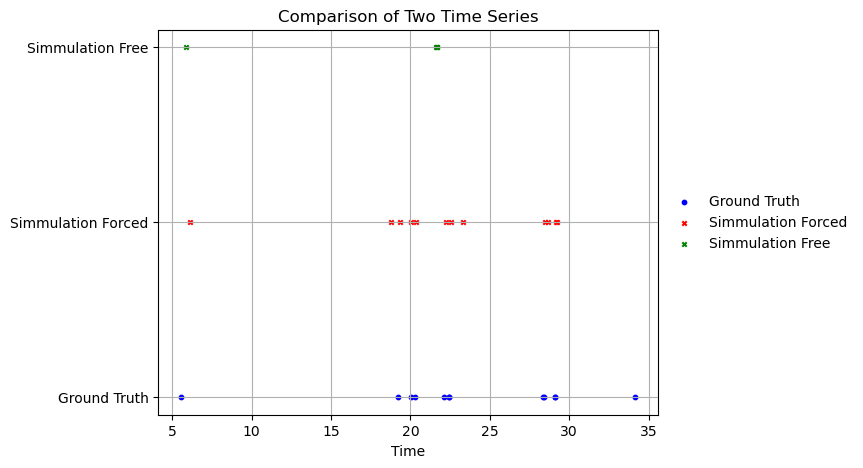

In [ ]:
time_series_1 = sample_path[0] # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


# Combined Models old

In [ ]:
# parameter dicts
width= 32
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width],
                                        "noise": 0},
                        "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

In [ ]:
import torch.optim as optim

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, "num_interaction_outcomes": num_interaction_types,
        "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
        "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
        "jump_model": jump_state_dict, "user_params_size": state_size,
        "noise": .01}
model = User_simmulation_Model(hyperparameter_dict)
#model = Conditioned_User_simmulation_Model(hyperparameter_dict)

In [ ]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                 experiment_name, "user_model.h5")
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
num_epochs = 10
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2
user_lr = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [ ]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([-0.0650], dtype=torch.float64), tensor([0.0293], dtype=torch.float64), tensor([0.0160], dtype=torch.float64), tensor([0.0170], dtype=torch.float64)]
logvar:  [tensor([-1.3569], dtype=torch.float64), tensor([-0.6309], dtype=torch.float64), tensor([-3.0378], dtype=torch.float64), tensor([-1.1676], dtype=torch.float64)]
means:  [tensor([0.5555], dtype=torch.float64), tensor([-0.5281], dtype=torch.float64), tensor([-0.4462], dtype=torch.float64), tensor([-0.5223], dtype=torch.float64)]
logvar:  [tensor([-2.9949], dtype=torch.float64), tensor([-1.3232], dtype=torch.float64), tensor([-2.9254], dtype=torch.float64), tensor([-1.1151], dtype=torch.float64)]
means:  [tensor([0.0046], dtype=torch.float64), tensor([0.1227], dtype=torch.float64), tensor([-0.2567], dtype=torch.float64), tensor([0.1705], dtype=torch.float64)]
logvar:  [tensor([-3.0190], dtype=torch.float64), tensor([-2.8460], dtype=torch.float64), tensor([-4.4657], dtype=torch.float64), tensor([-4.9160], dtype=torch.

: 

In [ ]:
# no negative samples
with torch.autograd.set_detect_anomaly(True):
        train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=utils.loss_func, 
                loss_func_kl=utils.kl_loss, kl_weight=kl_weight, user_lr=user_lr, conditioned=conditioned,
                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
                logger=utils.logging_func, warmup_period=warmup_period, 
                intensity_loss_func=utils.square_intensity_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                )


  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss_all: 83.185 	loss_base: 10.408 	loss_kl: 11.211 	loss_intensity:  61.566 	log of the loss: 1.92
loss_all: 177.653 	loss_base: 20.356 	loss_kl: 33.775 	loss_intensity:  123.523 	log of the loss: 2.25
loss_all: 329.329 	loss_base: 66.809 	loss_kl: 77.167 	loss_intensity:  185.353 	log of the loss: 2.52
loss_all: 421.758 	loss_base: 78.782 	loss_kl: 105.552 	loss_intensity:  237.423 	log of the loss: 2.63


In [ ]:
adsaf 

NameError: name 'adsaf' is not defined

In [ ]:
train_with_negatives(model, dataloader=dataloader, num_epochs=num_epochs, device=device, 
                loss_func=utils.loss_func, loss_func_kl=utils.kl_loss, kl_weight=kl_weight, 
                user_lr=user_lr, optimizer=optimizer, lr_scheduler=lr_scheduler, 
                num_classes=num_interaction_types, logger=utils.logging_func,
                warmup_period=warmup_period, intensity_loss_func=utils.log_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                num_negatives=num_negatives, positive_examples_weight=5,conditioned=conditioned,
                )

  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 10%|█         | 1/10 [03:36<32:32, 216.99s/it]

loss_all: 6022.002 	loss_base: 1665.032 	loss_kl: 1009.140 	loss_intensity:  3347.830 	log of the loss: 3.78


 20%|██        | 2/10 [07:35<30:35, 229.43s/it]

loss_all: 5316.963 	loss_base: 1665.079 	loss_kl: 976.702 	loss_intensity:  2675.182 	log of the loss: 3.73


 30%|███       | 3/10 [11:40<27:37, 236.82s/it]

loss_all: 5213.752 	loss_base: 1665.184 	loss_kl: 948.971 	loss_intensity:  2599.597 	log of the loss: 3.72


 30%|███       | 3/10 [12:24<28:58, 248.32s/it]


KeyboardInterrupt: 

In [ ]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([0.0020], dtype=torch.float64), tensor([0.0003], dtype=torch.float64), tensor([-0.0003], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0076], dtype=torch.float64), tensor([-0.0022], dtype=torch.float64), tensor([0.0018], dtype=torch.float64)]
logvar:  [tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64)]
means:  [tensor([0.0010], dtype=torch.float64), tensor([0.0013], dtype=torch.float64), tensor([-0.0005], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0024], dtype=torch.float64), tensor([0.1395], dtype=torch.float64), tensor([-0.1428], dtype=torch.float64)]
logvar:  [tensor([-0.4619], dtype=torch.float64), tensor([-0.4619], dtype=torch.float64), tensor([-0

In [ ]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [ ]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path,
)


## visualize

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5020]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5026]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.4968]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5004]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.4659]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


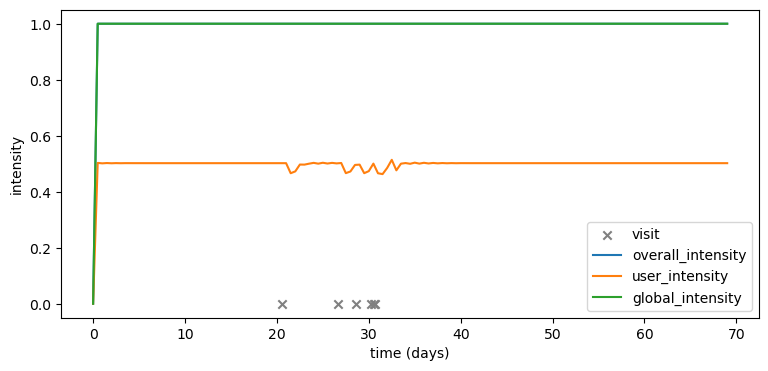

In [ ]:
# conditioned square continouous state + state_int new formulas
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, 
                dataset=dataloader.dataset, User_model = model, use_true_recommendations =True, 
                num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 6
overall_intensity:  tensor([[0.4791]]) 	user_intensity:  tensor([[0.4861]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4793]]) 	user_intensity:  tensor([[0.4862]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4425]]) 	user_intensity:  tensor([[0.4616]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4629]]) 	user_intensity:  tensor([[0.4753]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4884]]) 	user_intensity:  tensor([[0.4922]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


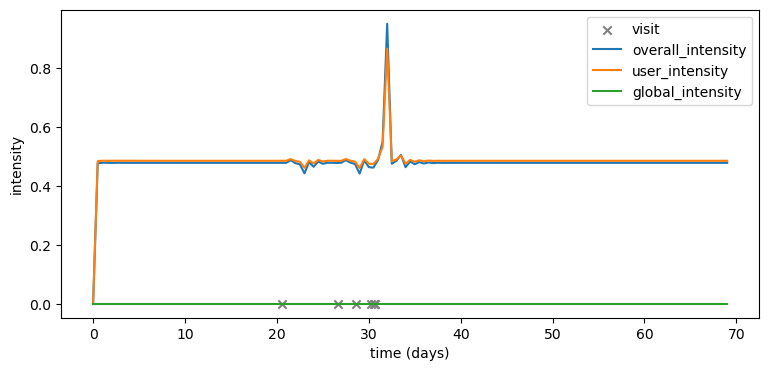

In [ ]:
# conditioned square continouous state + state_int
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.4997]]) 	user_intensity:  tensor([[0.4998]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4988]]) 	user_intensity:  tensor([[0.4992]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4539]]) 	user_intensity:  tensor([[0.4692]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4550]]) 	user_intensity:  tensor([[0.4699]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4708]]) 	user_intensity:  tensor([[0.4805]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


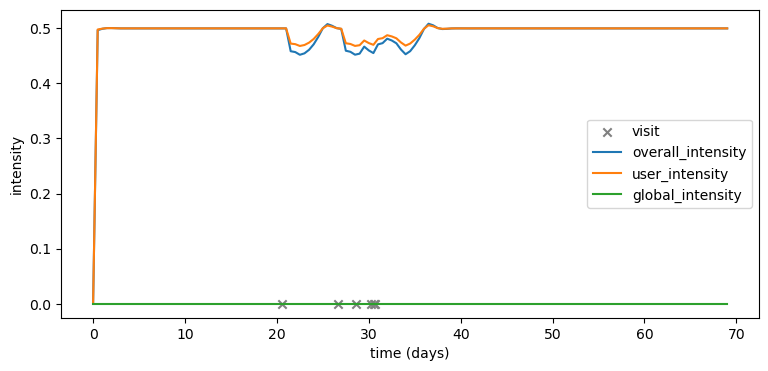

In [ ]:
# conditioned square continouous state
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 6
overall_intensity:  tensor([[0.4913]]) 	user_intensity:  tensor([[0.4942]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5027]]) 	user_intensity:  tensor([[0.5018]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5085]]) 	user_intensity:  tensor([[0.5056]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5214]]) 	user_intensity:  tensor([[0.5143]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5335]]) 	user_intensity:  tensor([[0.5223]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


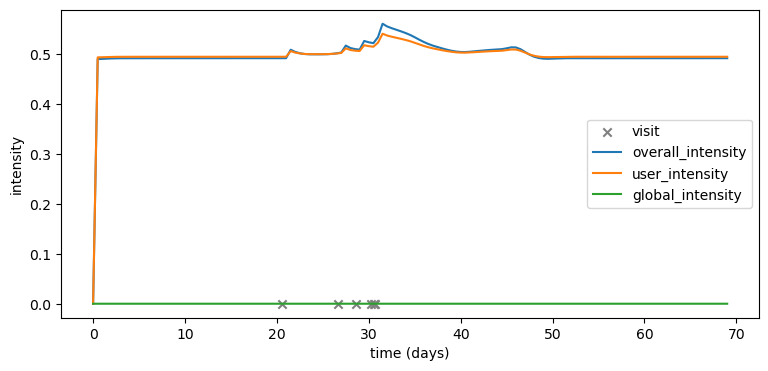

In [ ]:
# conditioned negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 7
overall_intensity:  tensor([[0.4873]]) 	user_intensity:  tensor([[0.4915]]) 	global_intensity:  tensor([4.8434e-29]) 	 before a recommendation.
overall_intensity:  tensor([[0.4734]]) 	user_intensity:  tensor([[0.4822]]) 	global_intensity:  tensor([4.7692e-39]) 	 before a recommendation.
overall_intensity:  tensor([[0.4891]]) 	user_intensity:  tensor([[0.4927]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4924]]) 	user_intensity:  tensor([[0.4950]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


overall_intensity:  tensor([[0.4925]]) 	user_intensity:  tensor([[0.4950]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4820]]) 	user_intensity:  tensor([[0.4880]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


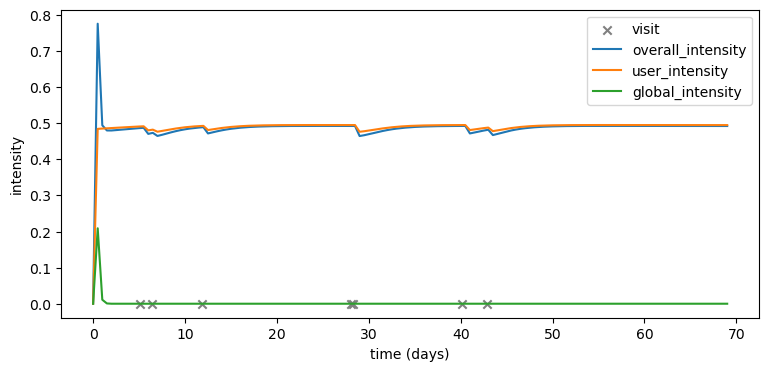

In [ ]:
# conditioned_square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=conditioned, increment=.5)

total visits for user 7
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5096]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.6996]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.6718]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5188]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5774]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.7162]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


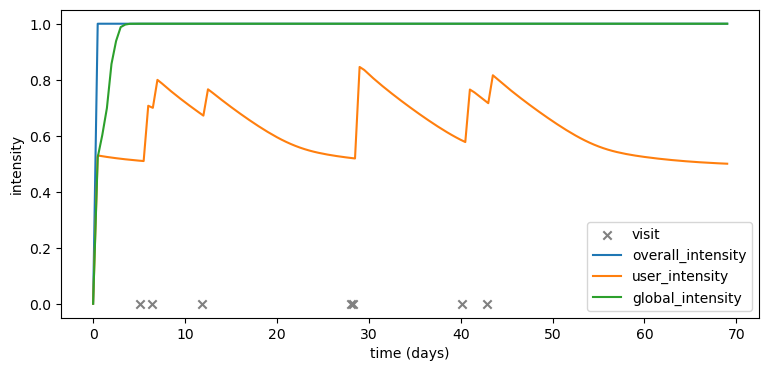

In [ ]:
# negative sampling  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.5)

total visits for user 7
overall_intensity:  tensor([[0.4996]]) 	user_intensity:  tensor([[0.4997]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4962]]) 	user_intensity:  tensor([[0.4975]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4761]]) 	user_intensity:  tensor([[0.4841]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4948]]) 	user_intensity:  tensor([[0.4965]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


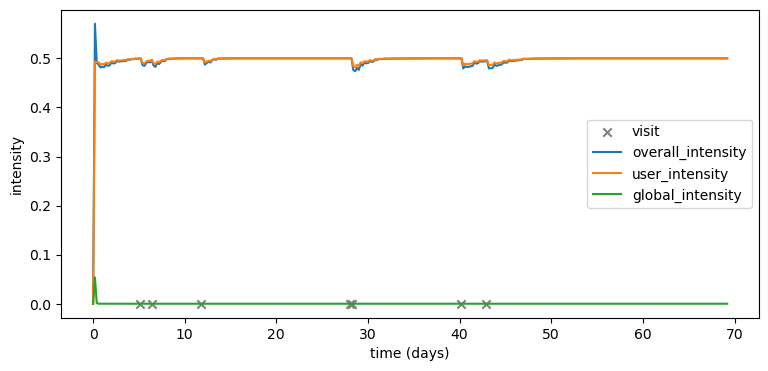

In [ ]:
# square  larger intervals train longer
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.2)

loaded sim_models
total visits for user 12
overall_intensity:  tensor([[0.4660]]) 	user_intensity:  tensor([[0.4773]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4668]]) 	user_intensity:  tensor([[0.4779]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.9060]]) 	user_intensity:  tensor([[0.8106]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.9868]]) 	user_intensity:  tensor([[0.9322]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


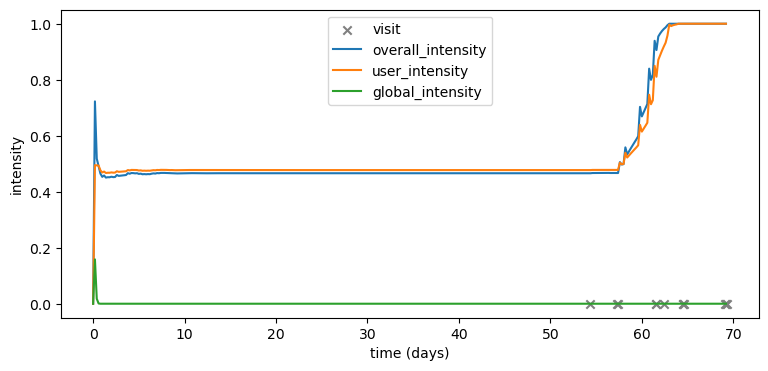

In [ ]:
# square  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1, conditioned=False, increment=.2)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.


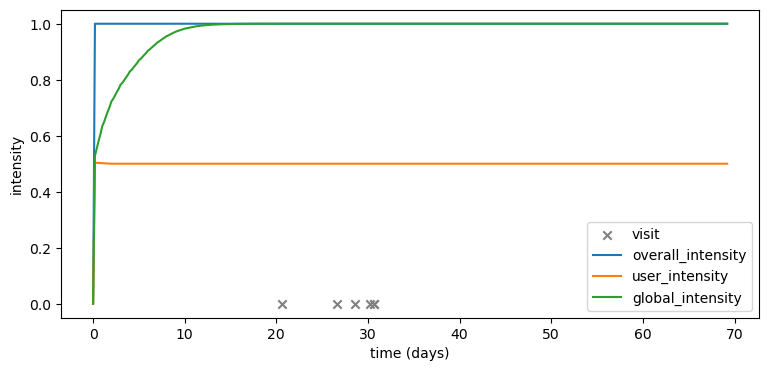

In [ ]:
# square continuous state integral
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=False)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


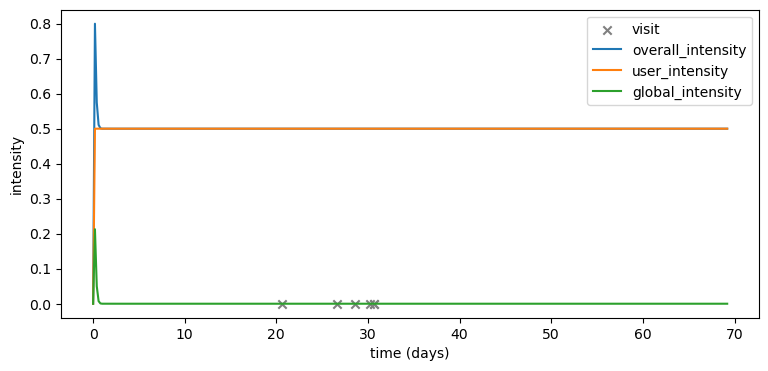

In [ ]:
# negative conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


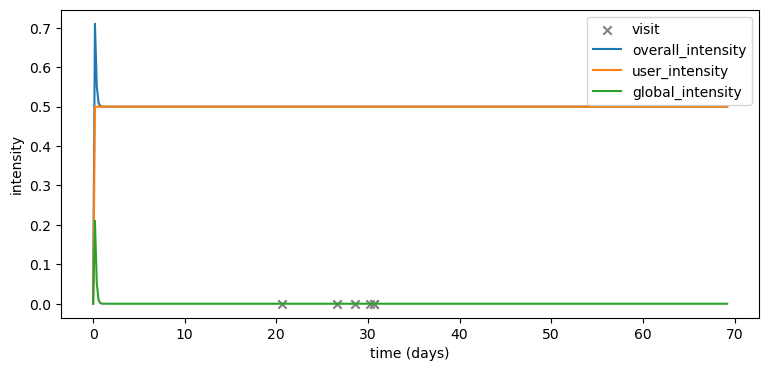

In [ ]:
# square conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


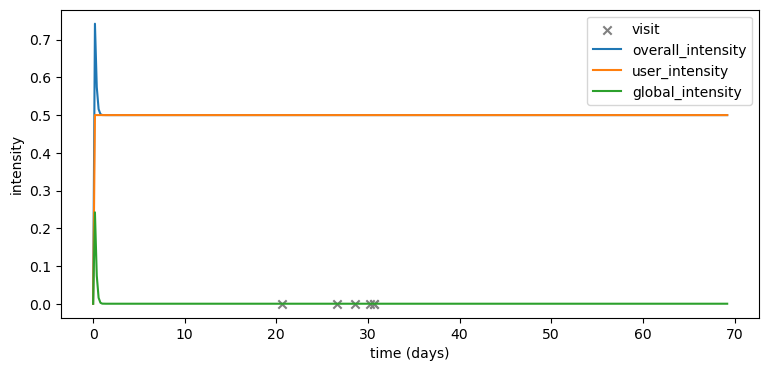

In [ ]:
# square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)

total visits for user 12
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


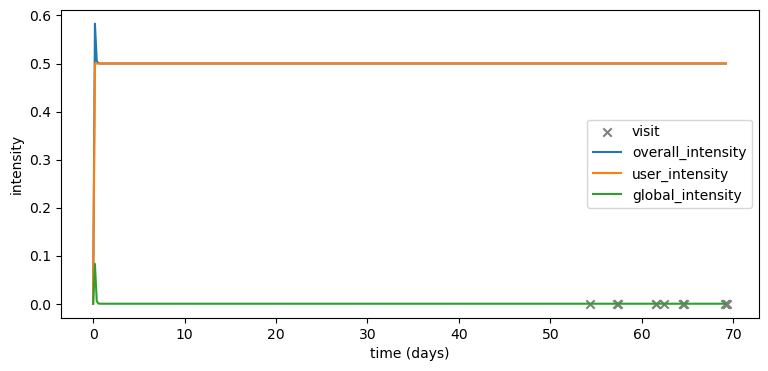

In [ ]:
#negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1)